## Text classification Sentiment Analysis - IMDB Dataset

In [16]:
#Imports & Globals
import os, re, random, string, html
import numpy as np
import pandas as pd
from tqdm.auto import tqdm

import nltk
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('punkt_tab', quiet=True)
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, classification_report, confusion_matrix
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import gensim
from gensim.models import Word2Vec, FastText

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import layers, models, callbacks

np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

In [14]:
df = pd.read_csv("/content/IMDB Dataset.csv")

In [17]:
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [18]:
df.shape

(50000, 2)

In [19]:
df['sentiment'].value_counts()

,count
sentiment,
positive,25000
negative,25000


wordcloud to see the word frequency

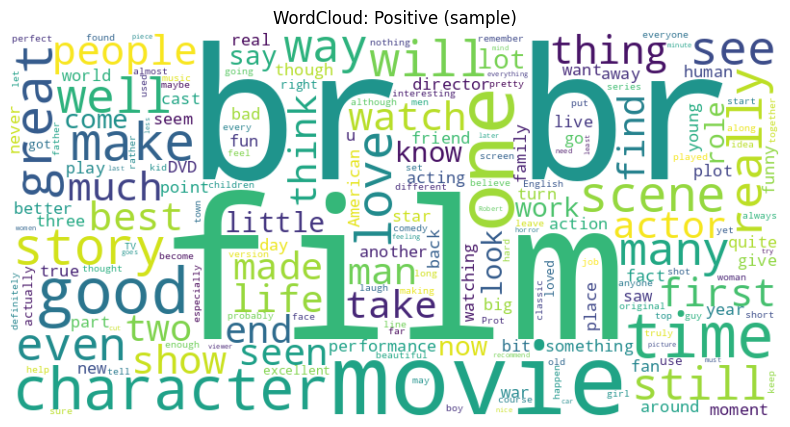

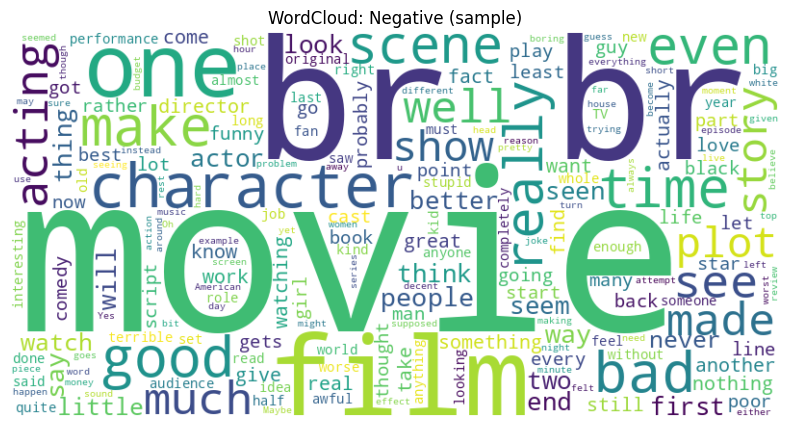

In [20]:
def show_wordcloud(texts, title):
    text = " ".join(texts)
    wc = WordCloud(width=800, height=400, background_color="white").generate(text)
    plt.figure(figsize=(10,5))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(title)
    plt.show()

sample_pos = df[df.sentiment=='positive'].review.sample(300, random_state=42).tolist()
sample_neg = df[df.sentiment=='negative'].review.sample(300, random_state=42).tolist()
show_wordcloud(sample_pos, "WordCloud: Positive (sample)")
show_wordcloud(sample_neg, "WordCloud: Negative (sample)")

In [21]:
df['sentiment'] = df['sentiment'].map({'positive': 1, 'negative': 0})

In [22]:
nltk.download('stopwords')
nltk.download('punkt')

stop_words = set(stopwords.words("english"))

def preprocess_text(text):
    text = re.sub(r"<br />", " ", text)           # remove HTML tags
    text = re.sub(r"[^a-zA-Z\s]", "", text)       # keep only letters
    text = text.lower()
    tokens = word_tokenize(text)                  # tokenize
    tokens = [w for w in tokens if w not in stop_words]  # remove stopwords
    return " ".join(tokens)

df["cleaned_review"] = df["review"].apply(preprocess_text)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [24]:
X_train, X_test, y_train, y_test = train_test_split(
    df["cleaned_review"], df["sentiment"],
    test_size=0.2, random_state=42
)

In [25]:
df.tail()

,review,sentiment,cleaned_review
49995,I thought this movie did a down right good job...,1,thought movie right good job wasnt creative or...
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",0,bad plot bad dialogue bad acting idiotic direc...
49997,I am a Catholic taught in parochial elementary...,0,catholic taught parochial elementary schools n...
49998,I'm going to have to disagree with the previou...,0,im going disagree previous comment side maltin...
49999,No one expects the Star Trek movies to be high...,0,one expects star trek movies high art fans exp...


In [26]:

tfidf = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)


Word2vec model

In [29]:

train_tokens = [text.split() for text in X_train]
w2v_model = Word2Vec(sentences=train_tokens, vector_size=100, window=5, min_count=5, workers=4)


def get_avg_vector(text, model):
    tokens = text.split()
    vectors = [model.wv[w] for w in tokens if w in model.wv]
    return np.mean(vectors, axis=0) if vectors else np.zeros(100)

X_train_w2v = np.array([get_avg_vector(text, w2v_model) for text in X_train])
X_test_w2v = np.array([get_avg_vector(text, w2v_model) for text in X_test])


In [32]:
X_test_w2v.shape

(10000, 100)

Fast Text

handles out of vocabulary words

In [28]:
from gensim.models import FastText

fasttext_model = FastText(sentences=train_tokens, vector_size=100, window=5, min_count=5, workers=4)

X_train_ft = np.array([get_avg_vector(text, fasttext_model) for text in X_train])
X_test_ft = np.array([get_avg_vector(text, fasttext_model) for text in X_test])


In [30]:
X_train_ft

array([[-0.05034569,  0.1488466 , -0.87381303, ..., -0.08636022,
         0.06230543, -0.31096214],
       [-0.29930818, -0.12139639, -0.78290164, ..., -0.19157006,
         0.0521344 , -0.17823477],
       [-0.48924255, -0.02259934, -0.25935534, ...,  0.01971564,
        -0.11411288, -0.37031034],
       ...,
       [ 0.30685967, -0.12409416, -1.5254545 , ..., -0.42633766,
        -0.2660874 ,  0.26380837],
       [ 0.09309133, -0.30311933, -0.9749922 , ..., -0.04379713,
        -0.31899044, -0.6001817 ],
       [-0.69900024,  0.6579462 , -0.56624913, ...,  0.36808065,
         0.10455155, -0.768587  ]], dtype=float32)

Logreg

In [33]:
from sklearn.linear_model import LogisticRegression

# Train on TF-IDF
clf_tfidf = LogisticRegression(max_iter=1000)
clf_tfidf.fit(X_train_tfidf, y_train)

# Train on Word2Vec
clf_w2v = LogisticRegression(max_iter=1000)
clf_w2v.fit(X_train_w2v, y_train)

# Train on fastText
clf_ft = LogisticRegression(max_iter=1000)
clf_ft.fit(X_train_ft, y_train)


LogisticRegression(max_iter=1000)

In [34]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report

def evaluate(model, X_test, y_test, name):
    y_pred = model.predict(X_test)
    print(f"--- {name} ---")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("F1-score:", f1_score(y_test, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))

evaluate(clf_tfidf, X_test_tfidf, y_test, "TF-IDF")
evaluate(clf_w2v, X_test_w2v, y_test, "Word2Vec")
evaluate(clf_ft, X_test_ft, y_test, "fastText")


--- TF-IDF ---
Accuracy: 0.8886
F1-score: 0.8909553641346907
Confusion Matrix:
 [[4335  626]
 [ 488 4551]]
              precision    recall  f1-score   support

           0       0.90      0.87      0.89      4961
           1       0.88      0.90      0.89      5039

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000

--- Word2Vec ---
Accuracy: 0.8589
F1-score: 0.8611903590752582
Confusion Matrix:
 [[4212  749]
 [ 662 4377]]
              precision    recall  f1-score   support

           0       0.86      0.85      0.86      4961
           1       0.85      0.87      0.86      5039

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000

--- fastText ---
Accuracy: 0.8464
F1-score: 0.8486401261332283
Confusion Matrix:
 [[4158  803]
 [ 733 4306]]
              precisi

## Support Vector Machine (SVM)

In [36]:
from sklearn.svm import LinearSVC

# Train on TF-IDF
clf_svm_tfidf = LinearSVC(max_iter=10000)
clf_svm_tfidf.fit(X_train_tfidf, y_train)

# Train on Word2Vec
clf_svm_w2v = LinearSVC(max_iter=10000)
clf_svm_w2v.fit(X_train_w2v, y_train)

# Train on fastText
clf_svm_ft = LinearSVC(max_iter=10000)
clf_svm_ft.fit(X_train_ft, y_train)

# Evaluate SVM models
evaluate(clf_svm_tfidf, X_test_tfidf, y_test, "SVM (TF-IDF)")
evaluate(clf_svm_w2v, X_test_w2v, y_test, "SVM (Word2Vec)")
evaluate(clf_svm_ft, X_test_ft, y_test, "SVM (fastText)")

--- SVM (TF-IDF) ---
Accuracy: 0.8802
F1-score: 0.8824568288854003
Confusion Matrix:
 [[4305  656]
 [ 542 4497]]
              precision    recall  f1-score   support

           0       0.89      0.87      0.88      4961
           1       0.87      0.89      0.88      5039

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000

--- SVM (Word2Vec) ---
Accuracy: 0.8585
F1-score: 0.8612064737616478
Confusion Matrix:
 [[4195  766]
 [ 649 4390]]
              precision    recall  f1-score   support

           0       0.87      0.85      0.86      4961
           1       0.85      0.87      0.86      5039

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000

--- SVM (fastText) ---
Accuracy: 0.8472
F1-score: 0.8495470657739267
Confusion Matrix:
 [[4158  803]
 [ 725 4314]]
   

## Neural Network (Simple Feedforward)

In [37]:
# Prepare data for Neural Network (using padded sequences for sequential models or simple dense layers for averaged embeddings)
# For demonstration, we'll use Word2Vec and fastText averaged embeddings directly with Dense layers.
# For TF-IDF, we can also use Dense layers.

# Using TF-IDF
model_nn_tfidf = models.Sequential([
    layers.Dense(128, activation='relu', input_shape=(X_train_tfidf.shape[1],)),
    layers.Dropout(0.5),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])
model_nn_tfidf.compile(optimizer='adam',
                       loss='binary_crossentropy',
                       metrics=['accuracy'])
model_nn_tfidf.fit(X_train_tfidf, y_train, epochs=5, batch_size=32, validation_split=0.2)

# Using Word2Vec
model_nn_w2v = models.Sequential([
    layers.Dense(128, activation='relu', input_shape=(X_train_w2v.shape[1],)),
    layers.Dropout(0.5),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])
model_nn_w2v.compile(optimizer='adam',
                     loss='binary_crossentropy',
                     metrics=['accuracy'])
model_nn_w2v.fit(X_train_w2v, y_train, epochs=5, batch_size=32, validation_split=0.2)


# Using fastText
model_nn_ft = models.Sequential([
    layers.Dense(128, activation='relu', input_shape=(X_train_ft.shape[1],)),
    layers.Dropout(0.5),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])
model_nn_ft.compile(optimizer='adam',
                    loss='binary_crossentropy',
                    metrics=['accuracy'])
model_nn_ft.fit(X_train_ft, y_train, epochs=5, batch_size=32, validation_split=0.2)

# Evaluate Neural Network models
print("\n--- Neural Network (TF-IDF) ---")
loss_tfidf, accuracy_tfidf = model_nn_tfidf.evaluate(X_test_tfidf, y_test)
print(f"Loss: {loss_tfidf}, Accuracy: {accuracy_tfidf}")
# Note: For detailed evaluation metrics like F1-score, confusion matrix, and classification report for Neural Networks,
# you would typically predict probabilities/classes and use sklearn metrics functions.
# y_pred_nn_tfidf = (model_nn_tfidf.predict(X_test_tfidf) > 0.5).astype("int32")
# print(classification_report(y_test, y_pred_nn_tfidf))
# print(confusion_matrix(y_test, y_pred_nn_tfidf))


print("\n--- Neural Network (Word2Vec) ---")
loss_w2v, accuracy_w2v = model_nn_w2v.evaluate(X_test_w2v, y_test)
print(f"Loss: {loss_w2v}, Accuracy: {accuracy_w2v}")
# y_pred_nn_w2v = (model_nn_w2v.predict(X_test_w2v) > 0.5).astype("int32")
# print(classification_report(y_test, y_pred_nn_w2v))
# print(confusion_matrix(y_test, y_pred_nn_w2v))

print("\n--- Neural Network (fastText) ---")
loss_ft, accuracy_ft = model_nn_ft.evaluate(X_test_ft, y_test)
print(f"Loss: {loss_ft}, Accuracy: {accuracy_ft}")
# y_pred_nn_ft = (model_nn_ft.predict(X_test_ft) > 0.5).astype("int32")
# print(classification_report(y_test, y_pred_nn_ft))
# print(confusion_matrix(y_test, y_pred_nn_ft))

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 16s 14ms/step - accuracy: 0.7875 - loss: 0.4405 - val_accuracy: 0.8854 - val_loss: 0.2792
Epoch 2/5
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 18s 12ms/step - accuracy: 0.9030 - loss: 0.2446 - val_accuracy: 0.8809 - val_loss: 0.2949
Epoch 3/5
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 22s 14ms/step - accuracy: 0.9272 - loss: 0.1976 - val_accuracy: 0.8785 - val_loss: 0.3252
Epoch 4/5
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 22s 15ms/step - accuracy: 0.9495 - loss: 0.1498 - val_accuracy: 0.8751 - val_loss: 0.3796
Epoch 5/5
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 19s 14ms/step - accuracy: 0.9681 - loss: 0.1013 - val_accuracy: 0.8727 - val_loss: 0.4347
Epoch 1/5
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.7693 - loss: 0.4721 - val_accuracy: 0.8526 - val_loss: 0.3433
Epoch 2/5
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.8441 - loss: 0.3670 - val_accuracy: 0.8568 - val_loss: 0.3327
Epoch 3/5
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.8493 - loss: 0.3591 


    TF-IDF: Accuracy: 0.8731, Loss: 0.4164
    Word2Vec: Accuracy: 0.8614, Loss: 0.3270
    fastText: Accuracy: 0.8465, Loss: 0.3513


## t-SNE Visualization of Embeddings

In [ ]:

# Take sample embeddings for visualization
sample_embeddings = X_train_w2v[:1000]
sample_labels = y_train[:1000]

tsne = TSNE(n_components=2, random_state=42)
reduced = tsne.fit_transform(sample_embeddings)

plt.figure(figsize=(8,6))
plt.scatter(reduced[:,0], reduced[:,1], c=sample_labels, cmap="coolwarm", alpha=0.6)
plt.title("t-SNE visualization of Word2Vec embeddings")
plt.show()


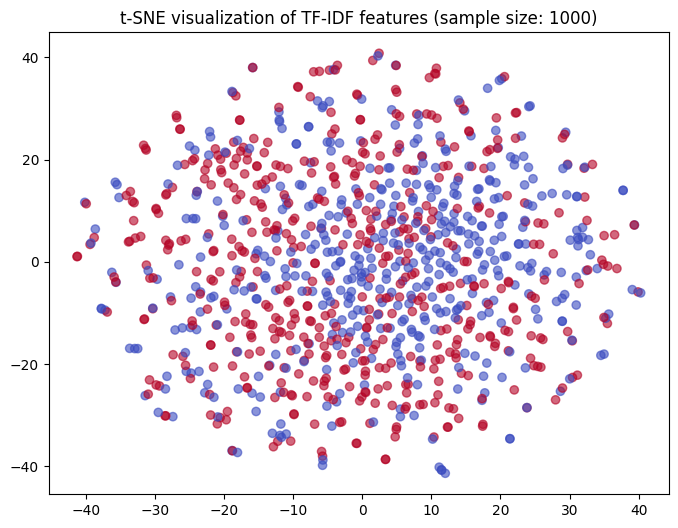

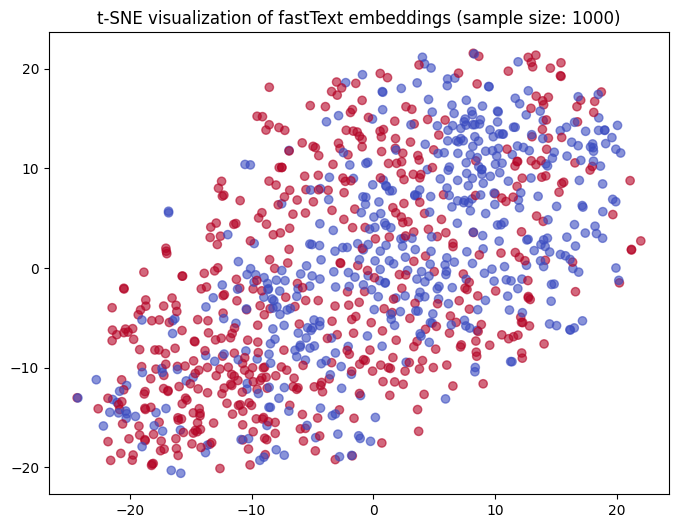

In [38]:

# Take sample embeddings for visualization (e.g., first 1000)
sample_size = 1000

# t-SNE for TF-IDF
# Note: TSNE on sparse matrices can be slow or require conversion.
# Let's convert to dense for simplicity for visualization purposes on a sample.
sample_embeddings_tfidf = X_train_tfidf[:sample_size].toarray()
sample_labels_tfidf = y_train[:sample_size]

tsne_tfidf = TSNE(n_components=2, random_state=42)
reduced_tfidf = tsne_tfidf.fit_transform(sample_embeddings_tfidf)

plt.figure(figsize=(8,6))
plt.scatter(reduced_tfidf[:,0], reduced_tfidf[:,1], c=sample_labels_tfidf, cmap="coolwarm", alpha=0.6)
plt.title(f"t-SNE visualization of TF-IDF features (sample size: {sample_size})")
plt.show()

# t-SNE for fastText
sample_embeddings_ft = X_train_ft[:sample_size]
sample_labels_ft = y_train[:sample_size]

tsne_ft = TSNE(n_components=2, random_state=42)
reduced_ft = tsne_ft.fit_transform(sample_embeddings_ft)

plt.figure(figsize=(8,6))
plt.scatter(reduced_ft[:,0], reduced_ft[:,1], c=sample_labels_ft, cmap="coolwarm", alpha=0.6)
plt.title(f"t-SNE visualization of fastText embeddings (sample size: {sample_size})")
plt.show()

## Exploring Stemming and Lemmatization

In [40]:
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import wordnet

# Download necessary resources for lemmatization
nltk.download('wordnet', quiet=True)
nltk.download('averaged_perceptron_tagger', quiet=True)
nltk.download('averaged_perceptron_tagger_eng', quiet=True)


stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

def get_wordnet_pos(word):
    """Map POS tag to first character used by WordNetLemmatizer"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

def preprocess_text_stemming(text):
    text = re.sub(r"<br />", " ", text)           # remove HTML tags
    text = re.sub(r"[^a-zA-Z\s]", "", text)       # keep only letters
    text = text.lower()
    tokens = word_tokenize(text)                  # tokenize
    tokens = [w for w in tokens if w not in stop_words]  # remove stopwords
    tokens = [stemmer.stem(w) for w in tokens]    # stemming
    return " ".join(tokens)

def preprocess_text_lemmatization(text):
    text = re.sub(r"<br />", " ", text)           # remove HTML tags
    text = re.sub(r"[^a-zA-Z\s]", "", text)       # keep only letters
    text = text.lower()
    tokens = word_tokenize(text)                  # tokenize
    tokens = [w for w in tokens if w not in stop_words]  # remove stopwords
    tokens = [lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in tokens] # lemmatization
    return " ".join(tokens)

# Apply the new preprocessing functions to a sample of the data
sample_reviews = df["review"].sample(5, random_state=42).tolist()

print("Original Reviews:")
for review in sample_reviews:
    print(f"- {review[:100]}...") # Print first 100 characters

print("\nStemmed Reviews:")
for review in sample_reviews:
    print(f"- {preprocess_text_stemming(review)[:100]}...") # Print first 100 characters

print("\nLemmatized Reviews:")
for review in sample_reviews:
    print(f"- {preprocess_text_lemmatization(review)[:100]}...") # Print first 100 characters

Original Reviews:
- I really liked this Summerslam due to the look of the arena, the curtains and just the look overall ...
- Not many television shows appeal to quite as many different kinds of fans like Farscape does...I kno...
- The film quickly gets to a major chase scene with ever increasing destruction. The first really bad ...
- Jane Austen would definitely approve of this one!<br /><br />Gwyneth Paltrow does an awesome job cap...
- Expectations were somewhat high for me when I went to see this movie, after all I thought Steve Care...

Stemmed Reviews:
- realli like summerslam due look arena curtain look overal interest reason anyway could one best summ...
- mani televis show appeal quit mani differ kind fan like farscap doesi know youngster year oldfan mal...
- film quickli get major chase scene ever increas destruct first realli bad thing guy hijack steven se...
- jane austen would definit approv one gwyneth paltrow awesom job captur attitud emma funni without ex...
- expect s

Stemming reduces words to their root form (e.g., "running" -> "run"), while lemmatization reduces words to their base or dictionary form (e.g., "better" -> "good").

Doing the same steps fFor lemmetization as Lemmatization is generally more accurate as it considers the word's context and dictionary form.

In [41]:
df["lemmatized_review"] = df["review"].apply(preprocess_text_lemmatization)

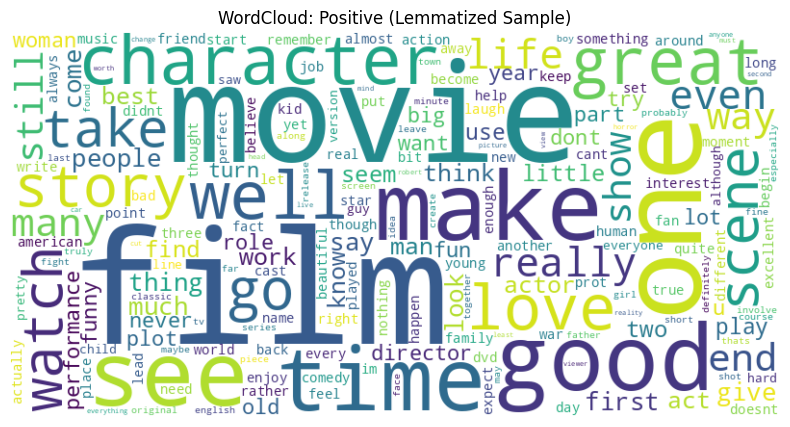

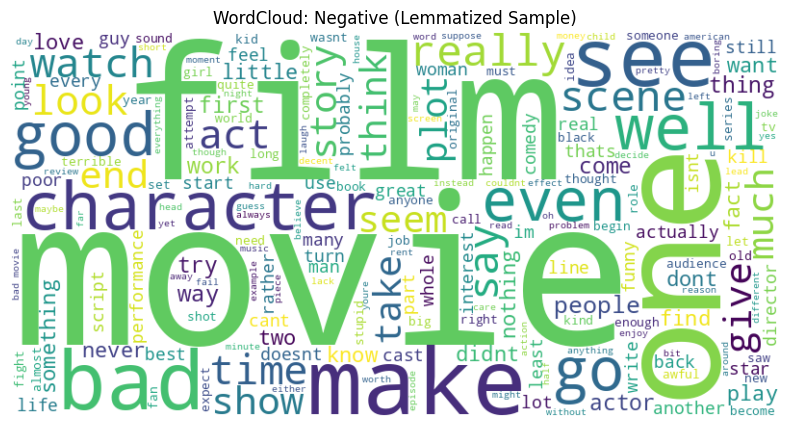

In [46]:
# Generate word cloud for lemmatized positive reviews
sample_pos_lemmatized = df[df.sentiment==1].lemmatized_review.sample(300, random_state=42).tolist()
show_wordcloud(sample_pos_lemmatized, "WordCloud: Positive (Lemmatized Sample)")

# Generate word cloud for lemmatized negative reviews
sample_neg_lemmatized = df[df.sentiment==0].lemmatized_review.sample(300, random_state=42).tolist()
show_wordcloud(sample_neg_lemmatized, "WordCloud: Negative (Lemmatized Sample)")

In [42]:
# Split data using the lemmatized reviews
X_train_lemmatized, X_test_lemmatized, y_train_lemmatized, y_test_lemmatized = train_test_split(
    df["lemmatized_review"], df["sentiment"],
    test_size=0.2, random_state=42
)

### Feature Extraction with Lemmatization

In [43]:
# TF-IDF with Lemmatization
tfidf_lemmatized = TfidfVectorizer(max_features=5000)
X_train_tfidf_lemmatized = tfidf_lemmatized.fit_transform(X_train_lemmatized)
X_test_tfidf_lemmatized = tfidf_lemmatized.transform(X_test_lemmatized)

print("TF-IDF (Lemmatized) shape:", X_train_tfidf_lemmatized.shape)

# Word2Vec with Lemmatization
# We need to tokenize the lemmatized text for Word2Vec
train_tokens_lemmatized = [text.split() for text in X_train_lemmatized]
w2v_model_lemmatized = Word2Vec(sentences=train_tokens_lemmatized, vector_size=100, window=5, min_count=5, workers=4)

X_train_w2v_lemmatized = np.array([get_avg_vector(text, w2v_model_lemmatized) for text in X_train_lemmatized])
X_test_w2v_lemmatized = np.array([get_avg_vector(text, w2v_model_lemmatized) for text in X_test_lemmatized])

print("Word2Vec (Lemmatized) shape:", X_train_w2v_lemmatized.shape)

# fastText with Lemmatization
fasttext_model_lemmatized = FastText(sentences=train_tokens_lemmatized, vector_size=100, window=5, min_count=5, workers=4)

X_train_ft_lemmatized = np.array([get_avg_vector(text, fasttext_model_lemmatized) for text in X_train_lemmatized])
X_test_ft_lemmatized = np.array([get_avg_vector(text, fasttext_model_lemmatized) for text in X_test_lemmatized])

print("fastText (Lemmatized) shape:", X_train_ft_lemmatized.shape)

TF-IDF (Lemmatized) shape: (40000, 5000)
Word2Vec (Lemmatized) shape: (40000, 100)
fastText (Lemmatized) shape: (40000, 100)


### Model Training and Evaluation with Lemmatization

In [44]:
# Logistic Regression with Lemmatization
clf_lemmatized = LogisticRegression(max_iter=1000)
clf_lemmatized.fit(X_train_tfidf_lemmatized, y_train_lemmatized)
evaluate(clf_lemmatized, X_test_tfidf_lemmatized, y_test_lemmatized, "Logistic Regression (TF-IDF Lemmatized)")

# SVM with Lemmatization
clf_svm_lemmatized = LinearSVC(max_iter=10000)
clf_svm_lemmatized.fit(X_train_tfidf_lemmatized, y_train_lemmatized)
evaluate(clf_svm_lemmatized, X_test_tfidf_lemmatized, y_test_lemmatized, "SVM (TF-IDF Lemmatized)")

# Neural Network with Lemmatization (using TF-IDF features for consistency with previous NN example)
model_nn_lemmatized = models.Sequential([
    layers.Dense(128, activation='relu', input_shape=(X_train_tfidf_lemmatized.shape[1],)),
    layers.Dropout(0.5),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])
model_nn_lemmatized.compile(optimizer='adam',
                           loss='binary_crossentropy',
                           metrics=['accuracy'])

# Use callbacks to stop training early if validation accuracy doesn't improve
early_stopping = callbacks.EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)

history_nn_lemmatized = model_nn_lemmatized.fit(X_train_tfidf_lemmatized, y_train_lemmatized,
                                               epochs=10, batch_size=32, validation_split=0.2,
                                               callbacks=[early_stopping])

print("\n--- Neural Network (TF-IDF Lemmatized) ---")
loss_nn_lemmatized, accuracy_nn_lemmatized = model_nn_lemmatized.evaluate(X_test_tfidf_lemmatized, y_test_lemmatized)
print(f"Loss: {loss_nn_lemmatized}, Accuracy: {accuracy_nn_lemmatized}")

# Note: For detailed evaluation metrics for Neural Networks, you would predict classes and use sklearn metrics functions
y_pred_nn_lemmatized = (model_nn_lemmatized.predict(X_test_tfidf_lemmatized) > 0.5).astype("int32")
print("Classification Report (Neural Network TF-IDF Lemmatized):\n", classification_report(y_test_lemmatized, y_pred_nn_lemmatized))
print("Confusion Matrix (Neural Network TF-IDF Lemmatized):\n", confusion_matrix(y_test_lemmatized, y_pred_nn_lemmatized))

# You would repeat the training and evaluation for Word2Vec and fastText lemmatized features as well
# using the Logistic Regression, SVM, and Neural Network models.

--- Logistic Regression (TF-IDF Lemmatized) ---
Accuracy: 0.885
F1-score: 0.8874094380262385
Confusion Matrix:
 [[4318  643]
 [ 507 4532]]
              precision    recall  f1-score   support

           0       0.89      0.87      0.88      4961
           1       0.88      0.90      0.89      5039

    accuracy                           0.89     10000
   macro avg       0.89      0.88      0.88     10000
weighted avg       0.89      0.89      0.88     10000

--- SVM (TF-IDF Lemmatized) ---
Accuracy: 0.8793
F1-score: 0.8815389145156541
Confusion Matrix:
 [[4302  659]
 [ 548 4491]]
              precision    recall  f1-score   support

           0       0.89      0.87      0.88      4961
           1       0.87      0.89      0.88      5039

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000



/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 15s 13ms/step - accuracy: 0.7877 - loss: 0.4418 - val_accuracy: 0.8836 - val_loss: 0.2771
Epoch 2/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 20s 13ms/step - accuracy: 0.8990 - loss: 0.2510 - val_accuracy: 0.8791 - val_loss: 0.2928
Epoch 3/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 20s 12ms/step - accuracy: 0.9285 - loss: 0.1967 - val_accuracy: 0.8730 - val_loss: 0.3286
Epoch 4/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - accuracy: 0.9496 - loss: 0.1454 - val_accuracy: 0.8712 - val_loss: 0.3805

--- Neural Network (TF-IDF Lemmatized) ---
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8815 - loss: 0.2750
Loss: 0.2757187485694885, Accuracy: 0.880299985408783
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Classification Report (Neural Network TF-IDF Lemmatized):
               precision    recall  f1-score   support

           0       0.90      0.86      0.88      4961
           1       0.86      0.90      0.88      5039

    accuracy                       

the models trained without lemmatization performed slightly better than those with lemmatization in terms of accuracy and F1-score for Logistic Regression and SVM. The Neural Network with lemmatization showed a slight improvement in accuracy compared to the one without lemmatization when using TF-IDF.